In [33]:
# See https://github.com/CINPLA/pyopenephys
%load_ext autoreload
%autoreload 2
import pyopenephys
from utils.custom_functions import *
import matplotlib.pylab as plt
import numpy as np
import math
import sys
import os
sys.path.append("../") # go to parent 
from BehaviouralAnalysis.utils.plot_utils import axvlines
import quantities as pq
from scipy.signal import filtfilt, find_peaks
import copy
import matplotlib
%matplotlib inline
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# 1. read data
GeneralDataDir = get_data_folder()
experiments_folder = '20200915'
# Create out directory if it does not exist
outputDir = GeneralDataDir + "/" + experiments_folder + '/Analyzed_data/'
if not os.path.isdir(outputDir):
    os.mkdir(outputDir)

experiments_list = [f for f in os.listdir(GeneralDataDir + experiments_folder + "/")\
                    if os.path.isdir(GeneralDataDir + experiments_folder + "/" + f)\
                    if 'experiment1' in os.listdir(GeneralDataDir + experiments_folder + "/" + f)]
for i,e in enumerate(experiments_list):
    print(i, ' -- ', e)

0  --  togetherWithPipette_slice3_2020-09-15_16-14-30_0.5ms_0.4power_1
1  --  togetherWithPipette_slice3_2020-09-15_16-24-55_0.5ms_0.4power_2
2  --  togetherWithPipette_slice3_2020-09-15_16-24-55_0.5ms_0.5power


In [11]:
# load experiment
Experiment = experiments_list[1]
number_of_channels = 64
print(Experiment)

file = pyopenephys.File(GeneralDataDir + experiments_folder + "/" + Experiment)
experiments = file.experiments
experiment1 = experiments[0]
recordings = experiment1.recordings
recording = recordings[0]
analog_signals = recording.analog_signals
signals = analog_signals[0]
events_data = recording.events
events = events_data[0]
print('Duration: ', recording.duration)
print('Sampling Rate: ', recording.sample_rate)

togetherWithPipette_slice3_2020-09-15_16-24-55_0.5ms_0.4power_2
Loading Open-Ephys: reading settings.xml...
Decoding data from  binary  format
.dat:  continuous.dat
Estimated samples:  4745472  Numchan:  72
Duration:  158.18236666666667 1/Hz
Sampling Rate:  30000.0 Hz


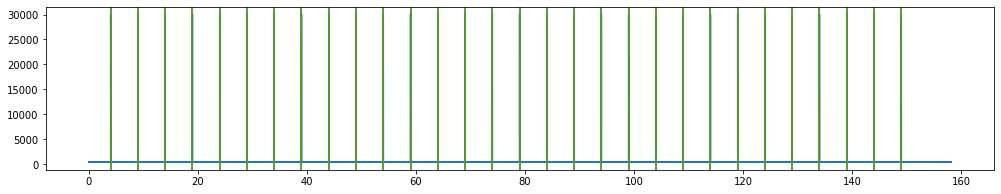

In [12]:
## ANALOG INPUT TO OE
# Alternatively, get the analog channel get the analog channel
analog_pulsepal = signals.signal[64]
# find mid point and get idxs above
#light_on_idx = np.where(analog_pulsepal > (max(analog_pulsepal) - min(analog_pulsepal))/2)[0]
light_on_idx = np.where(analog_pulsepal > (np.median(analog_pulsepal)*10))[0]
# indexes for onset, adding 1 because of np.diff
onset_idxofidx = np.where(np.diff(light_on_idx)>1)[0] + 1
offset_idxofidx = onset_idxofidx - 1
# add the first and last occurrence
onset_idxofidx = np.insert(onset_idxofidx, 0, 0)
offset_idxofidx = np.append(offset_idxofidx, len(light_on_idx)-1)
# get the times
onset_times = signals.times[light_on_idx[onset_idxofidx]]
offset_times = signals.times[light_on_idx[offset_idxofidx]]

# classify the pulses and save them into a diccionary
TTLs = {
        'soundPresentationTimes': onset_times,
        'soundOffsetTimes': offset_times
}
# get the difference (THIS ASSUMES IS ALWAYS THE SAME) For plotting purposes so far
offset_delay = np.median(TTLs['soundOffsetTimes'] - TTLs['soundPresentationTimes']).item()

# to test that works
plt.figure(figsize=(17,3))
plt.plot(signals.times, analog_pulsepal)
axvlines(onset_times, ax = plt.gca())
axvlines(offset_times, ax = plt.gca())
#plt.xlim(17.75,17.76)
#plt.xlim(61.737,61.7385)


Save results for looking at them online in bonsai [optional]

In [60]:
np.array(signals.signal).transpose().tofile('/mnt/c/Users/herny/Desktop/to_test_in_bonsai')

In [34]:
#test = np.array(signals.signal).transpose()
#test[500000:800000,].tofile('/mnt/c/Users/herny/Desktop/to_test_in_bonsai')

#### Filter [optional]

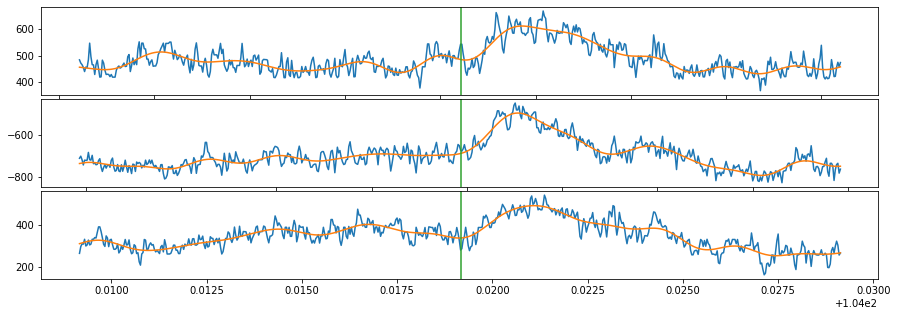

In [67]:
# FILTER TEST
ChID = 24
# 2. filter the data
Filter_High_Value = 1500
b, a = butter_lowpass(Filter_High_Value, recording.sample_rate)
fd = filtfilt(b, a, signals.signal[ChID])

# Plot some examples (first, 10th and 20th pulse)
fig, axs = plt.subplots(3, 1, figsize=(15, 5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .05, wspace=.1)
axs = axs.ravel()

for i in range(3):
    pulseTime = events.times[i*2*10].item() # *2 because TTLs come in pairs (beginning and end of pulse)
    pulseFrame = int(pulseTime * recording.sample_rate.item())
    pFS = int(pulseFrame - 0.01 * recording.sample_rate.item())
    pFF = int(pulseFrame + 0.01 * recording.sample_rate.item())
    #extract frames around the pulse
    axs[i].plot(signals.times[pFS:pFF], signals.signal[ChID][pFS:pFF])
    axs[i].plot(signals.times[pFS:pFF], fd[pFS:pFF])
    axvlines(pulseTime, ax = axs[i])

plt.show()


In [68]:
# filter the data
filtered_data = copy.deepcopy(signals.signal)
for electrodeID in range(number_of_channels):
    filtered_data[electrodeID] = filtfilt(b, a, signals.signal[electrodeID])
    update_progress(electrodeID / number_of_channels)
update_progress(1)

Progress: [####################] 100.0%


In [14]:
# override filtering
filtered_data = signals.signal

In [69]:
# align data
# interval for traces alignment. In seconds. Range of alignment
intervalWindow = [-0.02,0.04]
#firstpulses  = getFirstPulses(events.times, .5)
traces_aligned = alignTrace(filtered_data, signals.times, TTLs['soundPresentationTimes'], intervalWindow, recording.sample_rate)
intervalTimes = np.arange(intervalWindow[0], intervalWindow[1], 1/recording.sample_rate.base)
print(Experiment + ' analyzed...')

togetherWithPipette_slice3_2020-09-15_16-24-55_0.5ms_0.4power_2 analyzed...


In [70]:
# Translate data
# seconds to calculate the mean before 0 and translate each trace
sToSubstract = 0.005
traces_translated = copy.deepcopy(traces_aligned)
for electrodeID in range(len(traces_translated)):
    for traceID in range(len(traces_translated[electrodeID])):        
        traces_translated[electrodeID][traceID] = translateTrace(traces_aligned[electrodeID][traceID], intervalTimes, recording.sample_rate, sToSubstract)   
    update_progress(electrodeID / len(traces_translated))
update_progress(1)

Progress: [####################] 100.0%


In [28]:
# Override trace translation
traces_translated = copy.deepcopy(traces_aligned)

In [71]:
# Flip the traces
traces_translated = [-x for x in traces_translated]

Progress: [####################] 98.4%


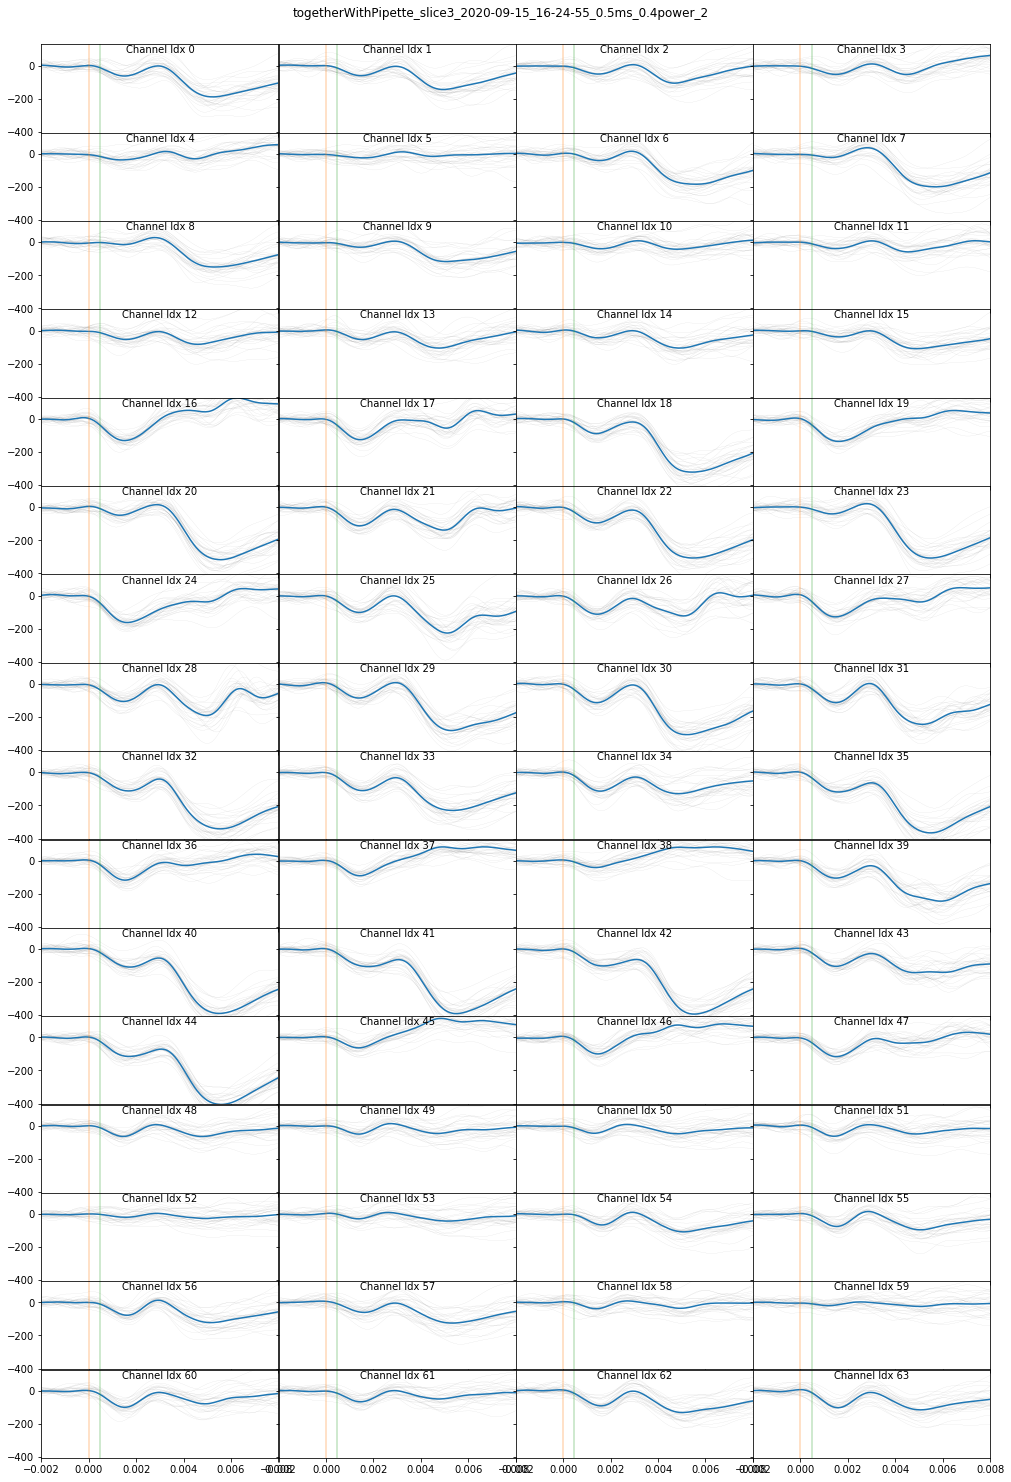

In [72]:
# Check-point. Plot the signal of each channel

fig, axs = plt.subplots(math.ceil(number_of_channels/4), 4, figsize=(17, 26), facecolor='w', edgecolor='k', sharex=True, sharey=True)
fig.subplots_adjust(hspace = .001, wspace=.001)
axs = axs.ravel()
plt.suptitle(Experiment, y=0.9)

# Save the averages
Average_traces = [None] * number_of_channels

for j in range(number_of_channels):
    for i in range(traces_translated[j].shape[0]):
        axs[j].plot(intervalTimes, traces_translated[j][i,], color = 'grey', linewidth = 0.1, alpha = 0.6)
    avg = np.mean(traces_translated[j], axis = 0)
    Average_traces[j] = avg
    axs[j].plot(intervalTimes, avg)
    # zoom in the curve
    axs[j].set_xlim(-0.002, 0.008)
    axs[j].text(.5,.9,"Channel Idx "+str(signals.channel_id[j]), horizontalalignment='center', transform=axs[j].transAxes)
    update_progress(j / number_of_channels)

for j in range(number_of_channels):    
    axvlines(0, alpha = 0.3, ax = axs[j])
    axvlines(offset_delay, alpha = 0.3, ax = axs[j])
    axs[j].set_ylim(np.min(Average_traces),np.max(Average_traces))
plt.savefig(outputDir + Experiment + '_AlignedSignal.pdf', transparent=True, bbox_inches='tight')
plt.show()

In [73]:
# check how they map to the electrodes in the probe
# micron coordinates
xcoords   = np.array([600, 600, 600, 600, 600, 600, 600, 600,
    630, 630, 630, 630, 630, 630, 630, 630,
    400, 400, 400, 400, 400, 400, 430, 430,
    430, 400, 430, 430, 430, 400, 430, 430,
    200, 200, 200, 230, 200, 200, 200, 230,
    200, 200, 230, 230, 230, 230, 230, 230,
    0, 0, 0, 0, 0, 0, 0, 0,
    30, 30, 30, 30, 30, 30, 30, 30])

# position in the shank from low to bottom
ycoords   = np.array([5, 7, 9, 11, 13, 15, 3, 1,
    0, 2, 14, 12, 10, 8, 6, 4,
    13, 11, 3, 15, 1, 9, 2, 0,
    14, 7, 10, 12, 8, 5, 4, 6,
    5, 7, 9, 4, 11, 13, 15, 6,
    3, 1, 0, 8, 2, 14, 12, 10,
    7, 5, 11, 9, 15, 13, 1, 3,
    2, 0, 12, 14, 8, 10, 4, 6])
# get the actual positions (how far up they are from the tip)
ycoords = ycoords * 23;

kcoords   = np.array([1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1,
    2, 2, 2, 2, 2, 2, 2, 2,
    2, 2, 2, 2, 2, 2, 2, 2,
    3, 3, 3, 3, 3, 3, 3, 3,
    3, 3, 3, 3, 3, 3, 3, 3,
    4, 4, 4, 4, 4, 4, 4, 4,
    4, 4, 4, 4, 4, 4, 4, 4]) #% grouping of channels (i.e. tetrode groups)

Progress: [####################] 98.4%


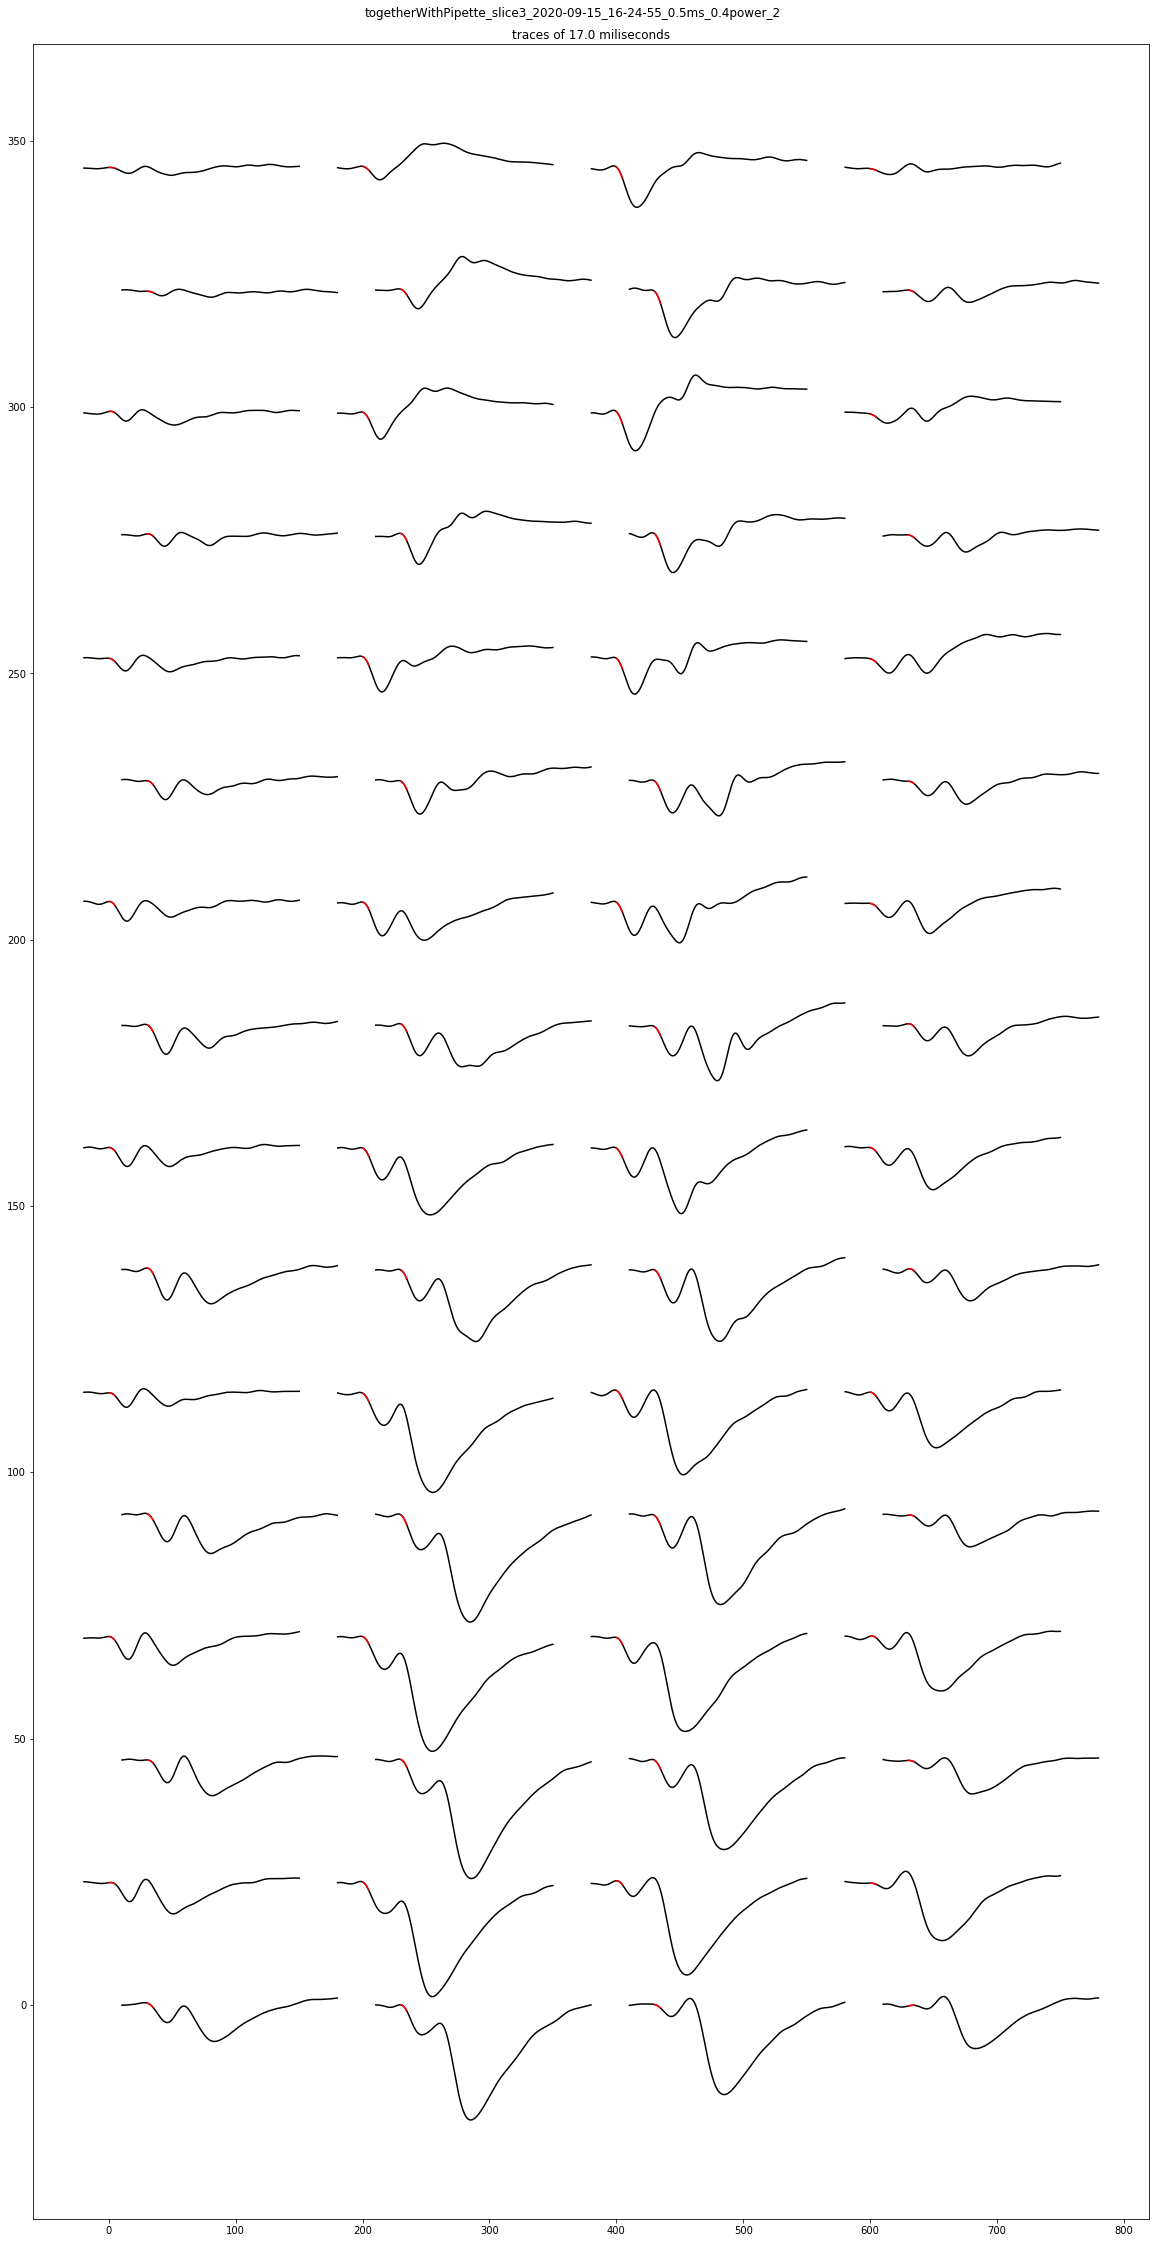

In [74]:
# This is like looking at the probe from the front

# select times to plot
from_seconds = -0.002
to_seconds = 0.015
iTvals = (intervalTimes > from_seconds) * (intervalTimes < to_seconds)
idx = np.where(iTvals)
light_idx = np.where((intervalTimes > 0) * (intervalTimes < offset_delay))


fig, axs = plt.subplots(1,1, figsize=(20, 40), facecolor='w', edgecolor='k', sharex=True, sharey='row')
fig.subplots_adjust(hspace = .001, wspace=.001)
#axs = axs.ravel()
x_scaler = 10000
y_scaler = 0.055
plt.title('traces of {} miliseconds'.format(1000 * (to_seconds - from_seconds)))
plt.suptitle(Experiment, y=0.893)
for j in range(len(xcoords)):
    axs.plot(xcoords[j] + intervalTimes[idx] * x_scaler,
             ycoords[j] + Average_traces[j][idx] * y_scaler,
             color = 'k')
    # plot when the light is on
    axs.plot(xcoords[j] + intervalTimes[light_idx] * x_scaler,
             ycoords[j] + Average_traces[j][light_idx] * y_scaler,
             color = 'r')
    update_progress(j / len(xcoords))
    
#for j in range(len(traces_translated)):    
#    axvlines(0, alpha = 0.3, ax = axs[j])
#    axvlines(offset_delay, alpha = 0.3, ax = axs[j])
plt.savefig(outputDir + Experiment + '_AlignedSignal.pdf', transparent=True, bbox_inches='tight')
plt.show()

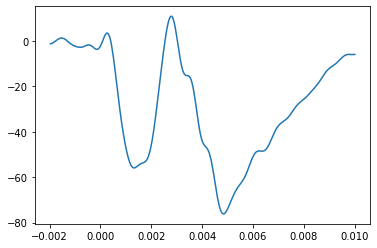

In [31]:
plt.plot(intervalTimes[idx],np.mean(np.array(Average_traces)[xcoords<100], axis=0)[idx])

In [ ]:
np.array(Average_traces)[ycoords<30].shape

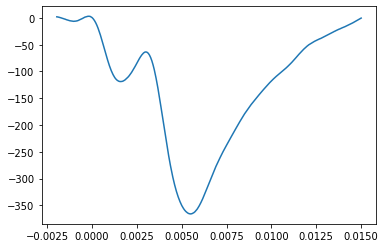

In [75]:
j=35
plt.plot(intervalTimes[idx], Average_traces[j][idx])

Progress: [####################] 100.0%


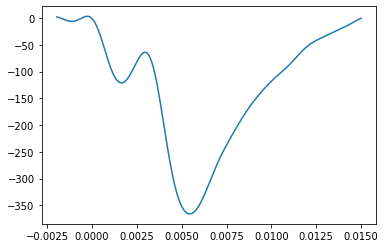

In [77]:
# Filter it so it fixes the derivative
Filter_High_Value = 600
b, a = butter_lowpass(Filter_High_Value, recording.sample_rate)

filtered_averages = copy.deepcopy(Average_traces)
for electrodeID in range(number_of_channels):
    filtered_averages[electrodeID] = filtfilt(b, a, Average_traces[electrodeID])
    update_progress(electrodeID / number_of_channels)
update_progress(1)
plt.plot(intervalTimes[idx], filtered_averages[j][idx])

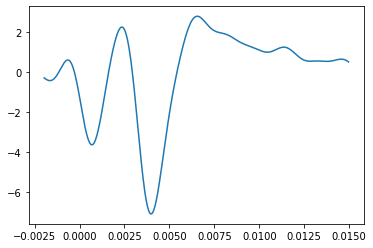

In [78]:
# Get the data for the electrode for the LFP frames
ElectrodeLFPData = [filtered_averages[j][idx] for j in range(len(filtered_averages))]
ElectrodeLFPTimes = intervalTimes[idx]

Derivatives = np.diff(ElectrodeLFPData, axis = 1)
DerivativeTimes = ElectrodeLFPTimes[:-1]

plt.plot(DerivativeTimes, Derivatives[j])

In [45]:
# Get the data for the electrode for the LFP frames
ElectrodeLFPData = [Average_traces[j][idx] for j in range(len(Average_traces))]
ElectrodeLFPTimes = intervalTimes[idx]

Derivatives = np.diff(ElectrodeLFPData, axis = 1)
DerivativeTimes = ElectrodeLFPTimes[:-1]
    
# for the minima of the ChR2 bump, find the first ascending 0 cross of the derivative after a specified time
MinChR2LowThr = 0.0015
MinChR2List = []
MinChR2ListIdx = []
MinChR2ListTime = []
for j in range(len(Derivatives)):
    if np.logical_and(np.logical_and(Derivatives[j]>=0, Derivatives[j] < 0), ElectrodeLFPTimes[j] > MinChR2LowThr):
        MinChR2ListTime.append(ElectrodeLFPTimes[j])
        MinChR2List.append(ElectrodeLFPData[j])
        MinChR2ListIdx.append(j)
        break


# for the maximum slope of the LFP, find the biggest minima after that
DerMin = []
DerMinIdx = []
DerMinTime = []
for j in range(len(Derivatives)):
    peaks, _ = find_peaks(-1 * Derivatives[j])
    peaks = peaks[peaks>MinChR2ListIdx[j]]
    DerMin.append(np.min(Derivatives[j][peaks]))
    DerMinIdx.append(peaks[np.argmin(Derivatives[j][peaks])])
    DerMinTime.append(ElectrodeLFPTimes[j][DerMinIdx[j]])
    
    
fig, axs = plt.subplots(math.ceil(len(Derivatives)/3), 3, figsize=(18,15), facecolor='w', edgecolor='k', sharex=True, sharey='row')
fig.subplots_adjust(hspace = .001, wspace=.001)
axs = axs.ravel()
plt.suptitle('Electrode ID ' + str(ElectrodeID), y=0.9, x=0.5)
for j in range(len(Derivatives)):
    axs[j].plot(ElectrodeLFPTimes[j][:-1], Derivatives[j])
    axs[j].plot(DerMinTime[j], DerMin[j], "x", color = 'purple')
    #axs[j].plot(MinChR2ListTime[j], MinChR2List[j], "x", color = 'purple')
    axvlines(MinChR2ListTime[j], ax = axs[j])
    axs[j].axhline(0, color="gray", linestyle = '--')
    #axs[j].set_xlim(0.001, 0.002)
    axs[j].text(.5,.9,ShortFileNames[j], horizontalalignment='center', transform=axs[j].transAxes)

#fig.savefig(OutPutDir + 'ChannelID-' + str(ElectrodeID) + '_derivatives.pdf', transparent=True)
plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

## Batch run

Progress: [##################--] 90.0%


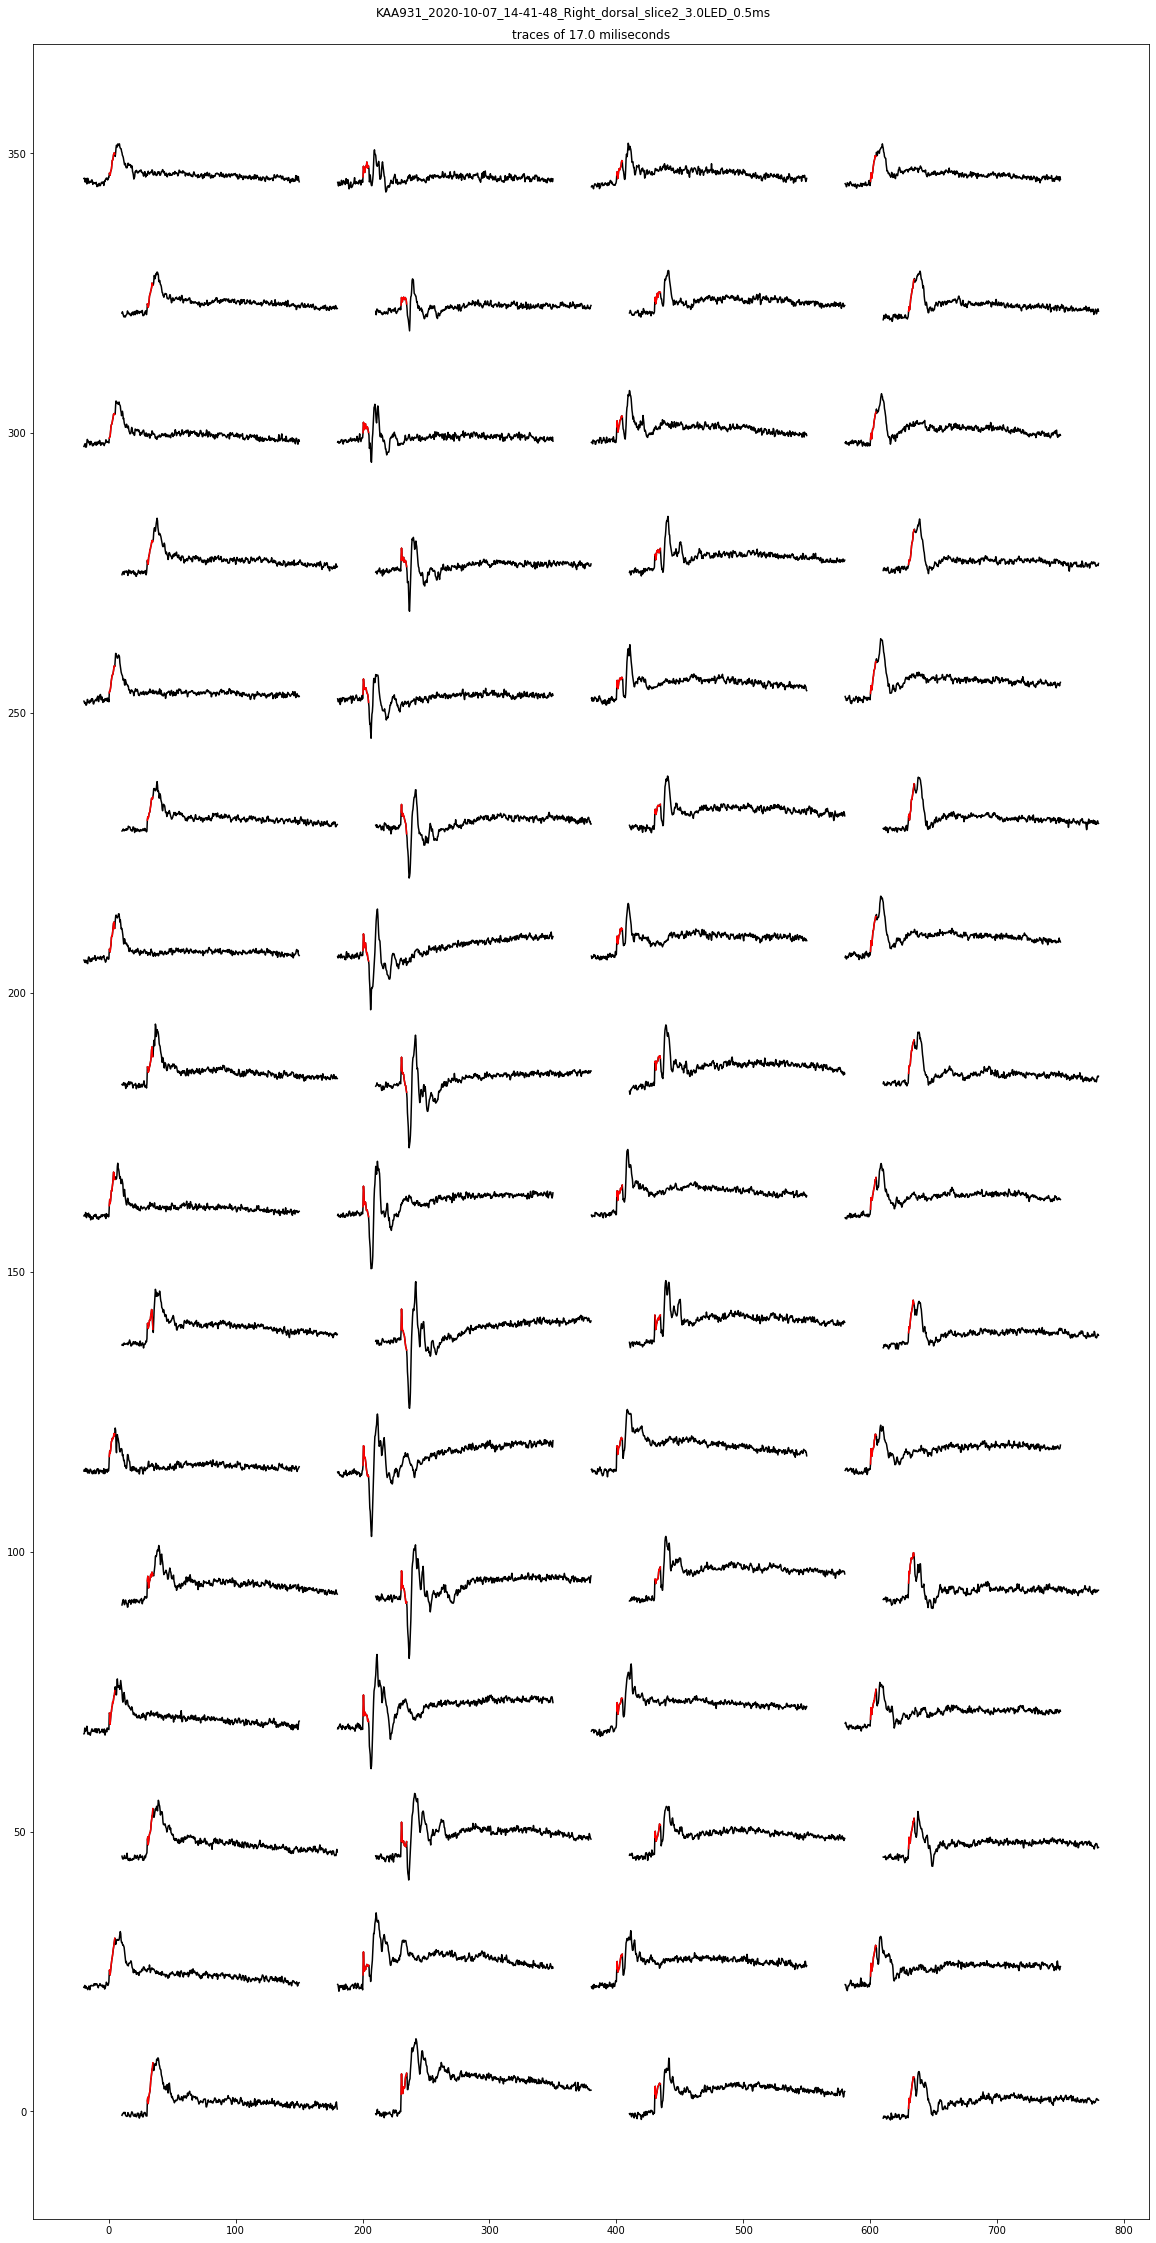

In [6]:
for i,e in enumerate(experiments_list):
    Experiment = e
    print(Experiment)
    number_of_channels = 64
    file = pyopenephys.File(GeneralDataDir + experiments_folder + '/' + Experiment)
    experiments = file.experiments
    experiment1 = experiments[0]
    recordings = experiment1.recordings
    recording = recordings[0]
    analog_signals = recording.analog_signals
    signals = analog_signals[0]
    events_data = recording.events
    events = events_data[0]



    ## ANALOG INPUT TO OE
    # Alternatively, get the analog channel get the analog channel
    analog_pulsepal = signals.signal[64]
    # find mid point and get idxs above
    #light_on_idx = np.where(analog_pulsepal > (max(analog_pulsepal) - min(analog_pulsepal))/2)[0]
    light_on_idx = np.where(analog_pulsepal > (np.median(analog_pulsepal)*10))[0]
    # indexes for onset, adding 1 because of np.diff
    onset_idxofidx = np.where(np.diff(light_on_idx)>1)[0] + 1
    offset_idxofidx = onset_idxofidx - 1
    # add the first and last occurrence
    onset_idxofidx = np.insert(onset_idxofidx, 0, 0)
    offset_idxofidx = np.append(offset_idxofidx, len(light_on_idx)-1)
    # get the times
    onset_times = signals.times[light_on_idx[onset_idxofidx]]
    offset_times = signals.times[light_on_idx[offset_idxofidx]]

    # classify the pulses and save them into a diccionary
    TTLs = {
            'soundPresentationTimes': onset_times,
            'soundOffsetTimes': offset_times
    }
    # get the difference (THIS ASSUMES IS ALWAYS THE SAME) For plotting purposes so far
    offset_delay = np.median(TTLs['soundOffsetTimes'] - TTLs['soundPresentationTimes']).item()



    # align data
    # interval for traces alignment. In seconds. Range of alignment
    intervalWindow = [-0.02,0.04]
    #firstpulses  = getFirstPulses(events.times, .5)
    traces_aligned = alignTrace(signals.signal, signals.times, TTLs['soundPresentationTimes'], intervalWindow, recording.sample_rate)
    intervalTimes = np.arange(intervalWindow[0], intervalWindow[1], 1/recording.sample_rate.base)
    # Override trace translation
    traces_translated = copy.deepcopy(traces_aligned)
    # Flip the traces
    traces_translated = [-x for x in traces_translated]   
    # Check-point. Plot the signal of each channel
    # Save the averages
    Average_traces = [None] * number_of_channels
    for j in range(number_of_channels):
        avg = np.mean(traces_translated[j], axis = 0)
        Average_traces[j] = avg
            
    # select times to plot
    from_seconds = -0.002
    to_seconds = 0.015
    iTvals = (intervalTimes > from_seconds) * (intervalTimes < to_seconds)
    idx = np.where(iTvals)
    light_idx = np.where((intervalTimes > 0) * (intervalTimes < offset_delay))


    fig, axs = plt.subplots(1,1, figsize=(20, 40), facecolor='w', edgecolor='k', sharex=True, sharey='row')
    fig.subplots_adjust(hspace = .001, wspace=.001)
    #axs = axs.ravel()
    x_scaler = 10000
    y_scaler = 0.055
    plt.title('traces of {} miliseconds'.format(1000 * (to_seconds - from_seconds)))
    plt.suptitle(Experiment, y=0.893)
    for j in range(len(xcoords)):
        axs.plot(xcoords[j] + intervalTimes[idx] * x_scaler,
                 ycoords[j] + Average_traces[j][idx] * y_scaler,
                 color = 'k')
        # plot when the light is on
        axs.plot(xcoords[j] + intervalTimes[light_idx] * x_scaler,
                 ycoords[j] + Average_traces[j][light_idx] * y_scaler,
                 color = 'r')

    plt.savefig(outputDir + Experiment + '_AlignedSignal.pdf', transparent=True, bbox_inches='tight')
    update_progress(i/len(experiments_list))
    plt.show()
    

In [ ]:
'''
# fix the timestamp.npy file. ONLY IF READING THE FILE FAILS
# this will probably make the digital ttls unusable
nchan = 72
subdir = '/experiment1/recording1/continuous/Rhythm_FPGA-101.0/'
tsfile = GeneralDataDir + Experiment + subdir + 'timestamps.npy'
#ts = np.load(tsfile)
ts.shape

contfile = GeneralDataDir + Experiment + subdir + 'continuous.dat'
contdata = np.fromfile(contfile, dtype=np.int16)
ts = np.array(range(int(contdata.shape[0]/nchan))).astype(np.int16)
np.save(tsfile, ts)
'''

***
### run one of the two cells below

In [ ]:
## DIGITAL INPUT TO OE
# get TTLs
rawTTLs = getTTLs(recording.events[0])[0]
# classify the pulses and save them into a diccionary
soundPresentationTimes = getFirstPulses(rawTTLs, 2) #Detect first events (separated by at least 2 seconds)
TTLs = {
        'soundPresentationTimes': soundPresentationTimes,
        'soundOffsetTimes': np.setdiff1d(rawTTLs, soundPresentationTimes), #get sound offset
}
# get the difference (THIS ASSUMES IS ALWAYS THE SAME) For plotting purposes so far
offset_delay = np.median(TTLs['soundOffsetTimes'] - TTLs['soundPresentationTimes']).item()

****
##### process data

In [ ]:
# FILTER TEST
ChID = 29
# 2. filter the data
Filter_Low_Value = 100
Filter_High_Value = 2000
filteredData = copy.deepcopy(signals.signal)
#b,a = butter_lowpass(600, recording.sample_rate)
b,a = butter_lowpass(Filter_High_Value, recording.sample_rate)
fd = filtfilt(b, a, signals.signal[ChID])

# Plot some examples (first, 5th, 10th and 15th pulse)
fig, axs = plt.subplots(6, 1, figsize=(15, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .05, wspace=.1)
axs = axs.ravel()

# every x pulses
every_x = 1

for i in range(6):
    pulseTime = TTLs['soundPresentationTimes'][i*every_x].item()
    pulseFrame = int(pulseTime * recording.sample_rate.item())
    pFS = int(pulseFrame - 0.01 * recording.sample_rate.item())
    pFF = int(pulseFrame + 0.01 * recording.sample_rate.item())
    #extract frames around the pulse
    axs[i].plot(signals.times[pFS:pFF],signals.signal[ChID][pFS:pFF])
    axs[i].plot(signals.times[pFS:pFF],fd[pFS:pFF])
    axvlines(pulseTime, ax=axs[i])
    axvlines(TTLs['soundOffsetTimes'][i*every_x].item(), ax=axs[i])

plt.show()


In [ ]:
# 2. filter the data
Filter_Low_Value = 100
Filter_High_Value = 800
filteredData = copy.deepcopy(signals.signal)
#b,a = butter_lowpass(600, recording.sample_rate)
b,a = butter_bandpass(Filter_Low_Value, Filter_High_Value, recording.sample_rate)
for electrodeID in range(64):
    filteredData[electrodeID] = filtfilt(b, a, signals.signal[electrodeID])
    update_progress(electrodeID / 64)
update_progress(1)

In [ ]:
# Check point
# Check how the filtered data looks like
# Select a channel
ChId = 16
# Plot some examples (first, 5th, 10th and 15th pulse)
fig, axs = plt.subplots(2, 2, figsize=(15, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .05, wspace=.1)
axs = axs.ravel()
plt.suptitle(Experiment + '_Filter channel ' + str(ChId), y=0.9)

for i in range(4):
    pulseTime = TTLs['soundPresentationTimes'][i*5].item()
    pulseFrame = int(pulseTime * recording.sample_rate.item())
    pFS = int(pulseFrame - 0.05 * recording.sample_rate.item())
    pFF = int(pulseFrame + 0.05 * recording.sample_rate.item())
    #extract frames around the pulse
    axs[i].plot(signals.times[pFS:pFF],signals.signal[ChId][pFS:pFF])
    axs[i].plot(signals.times[pFS:pFF],filteredData[ChId][pFS:pFF])
    axvlines(pulseTime, ax = axs[i])
    axvlines(TTLs['soundOffsetTimes'][i*5].item(), ax=axs[i])
#plt.savefig(OutPutDir + Experiment + '_FilteredSignal.pdf', transparent=True, bbox_inches='tight')
plt.show()

In [ ]:
# override filtering:
filteredData = copy.deepcopy(signals.signal)

In [ ]:
# Check point
# Check how the filtered data looks like
# Select a channel
ChId = 29
# Plot some examples (first, 10th, 20th and 30th pulse)
fig, axs = plt.subplots(1, 1, figsize=(17, 5), facecolor='w', edgecolor='k')
plt.suptitle(Experiment + '_Filter channel ' + str(ChId), y=0.9)
axs.plot(signals.times,signals.signal[ChId])
plt.show()

In [ ]:
# 3. align data
# interval for traces alignment. In seconds. Range of alignment
intervalWindow = [-0.02,0.04]
#firstpulses  = getFirstPulses(events.times, .5)
traces_aligned = alignTrace(filteredData, signals.times, TTLs['soundPresentationTimes'], intervalWindow, recording.sample_rate)
intervalTimes = np.arange(intervalWindow[0], intervalWindow[1], 1/recording.sample_rate.base)
print(Experiment + ' analyzed...')

In [ ]:
# 4. translate data
# seconds to calculate the mean before 0 and translate each trace
sToSubstract = 0.005
traces_translated = copy.deepcopy(traces_aligned)
for electrodeID in range(len(traces_translated)):
    for traceID in range(len(traces_translated[electrodeID])):        
        traces_translated[electrodeID][traceID] = translateTrace(traces_aligned[electrodeID][traceID], intervalTimes, recording.sample_rate, sToSubstract)   
    update_progress(electrodeID / len(traces_translated))
update_progress(1)

In [ ]:
# Override trace translation
traces_translated = copy.deepcopy(traces_aligned)

In [ ]:
# Check-point. Plot the signal of each channel
fig, axs = plt.subplots(math.ceil(number_of_channels/4), 4, figsize=(17, 26), facecolor='w', edgecolor='k', sharex=True, sharey=True)
fig.subplots_adjust(hspace = .001, wspace=.001)
axs = axs.ravel()
plt.suptitle(Experiment, y=0.9)

# Save the averages
Average_traces = [None] * number_of_channels

for j in range(number_of_channels):
    for i in range(traces_translated[j].shape[0]):
        axs[j].plot(intervalTimes, traces_translated[j][i,], color = 'grey', linewidth = 0.1, alpha = 0.6)
    avg = np.mean(traces_translated[j], axis = 0)
    Average_traces[j] = avg
    axs[j].plot(intervalTimes, avg)
    # zoom in the curve
    axs[j].set_xlim(-0.002, 0.02)
    axs[j].text(.5,.9,"Channel Idx "+str(signals.channel_id[j]), horizontalalignment='center', transform=axs[j].transAxes)
    update_progress(j / number_of_channels)

for j in range(number_of_channels):    
    axvlines(0, alpha = 0.3, ax = axs[j])
    axvlines(offset_delay, alpha = 0.3, ax = axs[j])
    axs[j].set_ylim(np.min(Average_traces),np.max(Average_traces))
#plt.savefig(OutPutDir + Experiment + '_AlignedSignal.pdf', transparent=True, bbox_inches='tight')
plt.show()

In [8]:
# check how they map to the electrodes in the probe
# micron coordinates
xcoords   = np.array([600, 600, 600, 600, 600, 600, 600, 600,
    630, 630, 630, 630, 630, 630, 630, 630,
    400, 400, 400, 400, 400, 400, 430, 430,
    430, 400, 430, 430, 430, 400, 430, 430,
    200, 200, 200, 230, 200, 200, 200, 230,
    200, 200, 230, 230, 230, 230, 230, 230,
    0, 0, 0, 0, 0, 0, 0, 0,
    30, 30, 30, 30, 30, 30, 30, 30])

# position in the shank from low to bottom
ycoords   = np.array([5, 7, 9, 11, 13, 15, 3, 1,
    0, 2, 14, 12, 10, 8, 6, 4,
    13, 11, 3, 15, 1, 9, 2, 0,
    14, 7, 10, 12, 8, 5, 4, 6,
    5, 7, 9, 4, 11, 13, 15, 6,
    3, 1, 0, 8, 2, 14, 12, 10,
    7, 5, 11, 9, 15, 13, 1, 3,
    2, 0, 12, 14, 8, 10, 4, 6])
# get the actual positions (how far up they are from the tip)
ycoords = ycoords * 23;

kcoords   = np.array([1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1,
    2, 2, 2, 2, 2, 2, 2, 2,
    2, 2, 2, 2, 2, 2, 2, 2,
    3, 3, 3, 3, 3, 3, 3, 3,
    3, 3, 3, 3, 3, 3, 3, 3,
    4, 4, 4, 4, 4, 4, 4, 4,
    4, 4, 4, 4, 4, 4, 4, 4]) #% grouping of channels (i.e. tetrode groups)


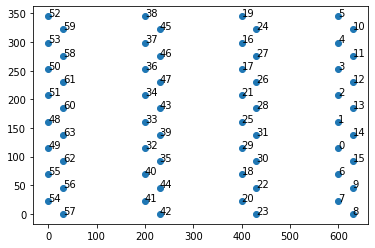

In [22]:
plt.plot(xcoords, ycoords, 'o')
for i in range(64):
    plt.text(xcoords[i], ycoords[i], str(i))

In [ ]:
# This is like looking at the probe from the front

# select times to plot
from_seconds = -0.002
to_seconds = 0.02
iTvals = (intervalTimes > from_seconds) * (intervalTimes < to_seconds)
idx = np.where(iTvals)

fig, axs = plt.subplots(1,1, figsize=(20, 40), facecolor='w', edgecolor='k', sharex=True, sharey='row')
fig.subplots_adjust(hspace = .001, wspace=.001)
#axs = axs.ravel()
x_scaler = 8000
y_scaler = 0.5
plt.suptitle(Experiment, y=0.9)
for j in range(len(xcoords)):
    axs.plot(xcoords[j] + intervalTimes[idx] * x_scaler, ycoords[j] + Average_traces[j][idx] * y_scaler)
    update_progress(j / len(xcoords))
    
#for j in range(len(traces_translated)):    
#    axvlines(0, alpha = 0.3, ax = axs[j])
#    axvlines(offset_delay, alpha = 0.3, ax = axs[j])
#plt.savefig(OutPutDir + Experiment + '_AlignedSignal.pdf', transparent=True, bbox_inches='tight')
plt.show()

In [ ]:
# plot the mean over each probe of the lower channels TODO
#fig, axs = plt.subplots(1,4, figsize=(20, 5), facecolor='w', edgecolor='k', sharex=True, sharey='row')
#fig.subplots_adjust(hspace = .001, wspace=.001)
plt.plot(intervalTimes[idx],np.mean(Average_traces, axis=0)[idx])